In [2]:
import pandas as pd
import numpy as np
import random
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os
import copy

In [3]:
df = pd.read_csv("../input/info.csv").iloc[:,1:]
df = df.set_index("Your name")

In [4]:
df.head()

,First Person,Second person,Third person,Fourth person,Fifth person
Your name,,,,,
1,13.0,12.0,78.0,8.0,34.0
2,61.0,42.0,39.0,3.0,69.0
3,61.0,39.0,2.0,69.0,44.0
4,37.0,21.0,14.0,28.0,51.0
5,43.0,7.0,30.0,41.0,32.0


In [5]:
class Graph():
    def getLabel(self,row,col,chart):
        label = ""
        person = chart[row][col]
        if person == 0: return "O",0
        choices = self.getChoices(person)
        total = 0
        NaPerson = self.NaPerson(person)
        
        if row != 0: 
            above = chart[row-1][col]
            rank = self.rank(above,choices)
            if type(rank)==int: total+=(6-rank)*.5
            if rank==None: rank = "x"
            if NaPerson: rank="n"
            label += str(rank)
        label += "\n"
        if col != 0: 
            left = chart[row][col-1]
            rank = self.rank(left,choices)
            if type(rank)==int: total+=6-rank
            if rank==None: rank = "x"
            if NaPerson: rank="n"
            label += str(rank)
        
        label += "       "
        label += str(int(person))
        label += "       "
        
        if col != self.numCols-1: 
            right = chart[row][col+1]
            rank = self.rank(right,choices)
            if type(rank)==int: total+=6-rank
            if rank==None: rank = "x"
            if NaPerson: rank="n"
            label += str(rank)
        label += "\n"
        if row != self.numRows-1: 
            below = chart[row+1][col]
            rank = self.rank(below,choices)
            if type(rank)==int: total+=(6-rank)*.5
            if rank==None: rank = "x"
            if NaPerson: rank="n"
            label += str(rank)
        if NaPerson: total = 4
        return label,total
            
        
    
    def Graph(self,chart):
        vals = [[self.getLabel(row,col,chart) for col in range(self.numCols)] for row in range(self.numRows)]
        labels = [[val[0] for val in row] for row in vals]
        #matrix = np.zeros((self.numRows,self.numCols)) 
        matrix = [[val[1] for val in row] for row in vals]
        plt.figure(figsize = (16,7))
        sns.heatmap(matrix, annot=labels, fmt="", cmap="Blues", cbar=False, linewidths=.5)
        plt.show()
        

In [6]:
class Evaluation:                  
    def VerticleHappiness(self, people, chart):
        HappyPeople = []
        for person in people:
            row, col = self.getRowColFromPerson(person)

            choices = self.getChoices(person)

            if row!=self.numRows-1:
                p = chart[row+1][col]
                rank = self.rank(p,choices)

                if rank in range(1,6) and person not in HappyPeople:
                    HappyPeople.append(person)


            if row!=0:
                p = chart[row-1][col]

                rank = self.rank(p,choices)
 
                if rank in range(1,6) and person not in HappyPeople:
                    HappyPeople.append(person)
        return HappyPeople
            
    def rank(self,p,choices):
        if p in choices: return choices.index(p)+1
        return None
    
    def EvaluateHappiness(self,chart):
        Score = {}
        Done = []
        for Level in range(1,6):
            
            HappyPeople = []
            NoPreferences = []
            UnhappyPeople = []
            
            for row in range(self.numRows):
                for col in range(self.numCols):
                    person = chart[row][col]
                    if person==0: continue
                
                    if self.NaPerson(person): 
                        NoPreferences.append(person)
                        continue

                    choices = self.getChoices(person)
                    
                    if col!=self.numCols-1:
                        p = chart[row][col+1]
                        
                        rank = self.rank(p,choices)
                        if rank == Level and person not in HappyPeople and person not in Done: 
                            HappyPeople.append(person)
                        
                        
                    if col!=0:
                        p = chart[row][col-1]
                        rank = self.rank(p,choices)
                        
                        if rank == Level and person not in HappyPeople and person not in Done:
                            HappyPeople.append(person)
                        
            Score[Level] = HappyPeople
            Done += HappyPeople
        
        
        numUnhappy = 94-len(NoPreferences)-len(Done)
        UnhappyPeople = [p for p in range(1,95) if p not in NoPreferences+Done]
        HaveVerticle = self.VerticleHappiness(UnhappyPeople, chart)
        numVerticleHappy = len(HaveVerticle)
        
#         for level in range(1,6):
#             print("Level %s, # of people %s" %(level, len(Score[level])))
        
        solution = FinalArrangement(chart,len(Score[1]), UnhappyPeople, HaveVerticle, len(NoPreferences))
        return solution
        
    
class FinalArrangement():
    def __init__(self,chart,numRankOne,UnhappyPeople,verticleHappy,NoPreferences):
        self.Chart = chart
        self.numRankOne = numRankOne
        self.UnhappyPeople = UnhappyPeople
        self.numUnhappy = len(self.UnhappyPeople)
        self.VerticleHappy = verticleHappy
        self.NoPreferences = NoPreferences
    def Print(self):
        print(self.Chart)
        print("Side by Side: First Choice:", self.numRankOne)
        print("# of people No Preferences", self.NoPreferences)
        print("Not in Top 5:", self.UnhappyPeople)
        print("Verticle Happy:", self.VerticleHappy)
        
        
class Solutions:
    def notSame(self, s,solution):
        return s.numRankOne != solution.numRankOne or s.numUnhappy != solution.numUnhappy
    def bestSolutions(self,solutions):
        bad = []
        for i,solution in enumerate(solutions):
            if list(filter(lambda s: s.numRankOne >= solution.numRankOne and s.numUnhappy <= solution.numUnhappy and self.notSame(s,solution), solutions)) != []:
                bad.append(i)
        nsolutions = [solution for i, solution in enumerate(solutions) if i not in bad]

        return nsolutions

    def printBestSolutions(self,solutions):
        for solution in solutions:
            solution.Print()
            self.Graph(solution.Chart)
            
            
    

In [7]:
class FunctionTools:
    def getRowColFromPerson(self,person):
        for row in range(self.numRows):
                for col in range(self.numCols):
                    p = self.Chart[row][col]
                    if person==p:
                        return row,col
                    
    def idealPairs(self):
        self.firsts = []
        for pair in self.matches:
            if pair["rank1"] in [1,2,None] and pair["rank2"] in [1,2,None]:
                self.firsts.append(pair)
    
    def makeDict(self, person1, rank1, person2, rank2):
        return {"person1":person1,"rank1":rank1,"person2":person2, "rank2":rank2}
    
    def getChoices(self,p):
        return list(self.df.loc[p])
    
    def removePersonFromMatches(self,person):
        return [pair for pair in matches if not (pair["person1"]==person or pair["person2"]==person)]
    
    def removePersonFromPeople(self,p, people):
        return [person for person in people if person != p]
        
                
    def getMatches(self,person):
        return [pair for pair in self.matches if pair["person1"]==person or pair["person2"]==person]
    
    
    def NaPerson(self,person):
        choices = self.getChoices(person)
        return np.isnan(choices).all()         
    
    def getPeople(self,pair):
        return [pair["person1"],pair["person2"]]
    
    def CompositeScore(self, pair):
        rank1 = pair["rank1"]
        rank2 = pair["rank2"]
        totalRank = rank2*2 if rank1 == None else (rank1*2 if rank2==None else rank1+rank2)
        return totalRank
    
    def findOtherPerson(self,pair, person):
        return pair["person1"] if person != pair["person1"] else pair["person2"]
    
    def findMatchPeople(self,matchesLeft,personLeft, matchesAbove, personAbove):
        peopleLeft = [self.findOtherPerson(pair, personLeft) for pair in matchesLeft]
        peopleAbove = [self.findOtherPerson(pair, personAbove) for pair in matchesAbove]
        return list(set(peopleLeft).union(set(peopleAbove)))
    
    def samePeople(self,pair, p1,p2):
        np1, np2 = pair["person1"],pair["person2"]
        if (np1 == p1 and np2==p2) or (np2 == p1 and np1==p2):
            return True
        return False
    
    
    def getMatch(self,p1,p2):
        match = [pair for pair in self.matches if self.samePeople(pair,p1,p2)]
        if len(match)==0:return None
        return match[0]
    
    def scorePair(self, pair):
        rank1 = pair["rank1"]
        rank2 = pair["rank2"]
        totalRank = rank2*2 if rank1 == None else (rank1*2 if rank2==None else rank1+rank2)
        return totalRank
    


In [25]:

class Students(Evaluation, FunctionTools, Solutions, Graph):
    df = pd.read_csv("../input/info.csv").iloc[:,1:]
    df = df.set_index("Your name")
    def __init__(self):
        self.numCols = 21
        self.numRows = 5
        self.matches()
        self.idealPairs()
        self.MatchesForLonelyPeople()
        self.stringPairs = []
        self.people = list(self.df.index)
        
        self.Read()
        
        
        for x in range(10):
            self.Chart = np.zeros((self.numRows,self.numCols))
            self.createString(self.people)
            solution = self.EvaluateHappiness(self.Chart)
            self.solutions.append(solution)

        self.bestSolutions = self.bestSolutions(self.solutions)
        self.printBestSolutions(self.bestSolutions)

        self.Dump()
    
    def Read(self):
        self.solutions = []
        if "solutions.pickle" in os.listdir("../output"):
            with open('../output/solutions.pickle', "rb") as file:
                self.solutions = pickle.load(file)
        print(len(self.solutions))
                
    def Dump(self):
        with open('../output/solutions.pickle', 'wb') as file:
            pickle.dump(self.solutions, file)
        
   
    def matches(self):
        matches = []
        for person,rankings in self.df.iterrows():
                for rank1,rankedPerson in enumerate(rankings):
                    if not pd.isnull(rankedPerson):
                        OtherPersonChoices = self.getChoices(rankedPerson)
                        if person in OtherPersonChoices:
                            if person > rankedPerson: continue #don't want duplicates if they overlap it will be added by first person
                            rank2 = OtherPersonChoices.index(person)
                            matches.append(self.makeDict(person,rank1+1,rankedPerson,rank2))
                        elif np.isnan(OtherPersonChoices).all():
                            matches.append(self.makeDict(person,rank1+1,rankedPerson,None))
        self.matches = matches
    
    def NoMatches(self):
        haveMatch = reduce(lambda a,b: a+b, [self.getPeople(pair) for pair in self.matches])
        return [p for p in range(1,95) if p not in haveMatch and not self.NaPerson(p)]
    
    def MatchesForLonelyPeople(self):
        needMatch = self.NoMatches()
        for person in needMatch:
            rankings = self.getChoices(person)
            for rank1,rankedPerson in enumerate(rankings):
                if not pd.isnull(rankedPerson):
                    self.matches.append(self.makeDict(person,rank1+1,rankedPerson,rank1+3))
                    
    def CompositeScore(self,person,personLeft, personAbove):
        if len(self.getMatches(person))==1: return -100
        matchLeft = self.getMatch(person,personLeft)
        matchAbove = self.getMatch(person,personAbove)
        
        if matchAbove == None:
            totalRankLeft = self.scorePair(matchLeft)
            return totalRankLeft
        if matchLeft == None:
            totalRankAbove = self.scorePair(matchAbove)
            return 100+totalRankAbove
        
        totalRankLeft = self.scorePair(matchLeft)
        totalRankAbove = 12-self.scorePair(matchAbove)
        return totalRankLeft-.5*(totalRankAbove)
        
    def lowestCompositeScore(self, row,col, people):
        
        personLeft = 0 if col==0 else self.Chart[row][col-1]
        personAbove = 0 if row==0 else self.Chart[row-1][col]
        if (personLeft==0 and personAbove==0): return None
        matchesLeft = self.getMatches(personLeft)
        matchesAbove = self.getMatches(personAbove)
 
        
        peopleOptions = self.findMatchPeople(matchesLeft,personLeft,matchesAbove, personAbove)
        peopleOptions = [person for person in peopleOptions if person in people]
        if len(peopleOptions)==0: return None
        scores = [self.CompositeScore(person, personLeft, personAbove) for person in peopleOptions]
        minScore = min(scores)
        bestPerson = peopleOptions[scores.index(minScore)]
        return bestPerson
        
    
    
    def newPosition(self,row,col):
        if col==self.numCols-1: 
            col =0
            row += 1
        else: col+=1
        return row,col
    def setLeftToZero(self,row,col):
        row,col = self.newPosition(row,col)
        while row!=self.numRows:
            self.Chart[row][col]=0
            row,col = self.newPosition(row,col)
            
    
    def createString(self, people, row=0, col=0):

        if row == self.numRows: return
        newPerson = self.lowestCompositeScore(row, col, people)
        nrow,ncol = self.newPosition(row,col)
        if newPerson==None:
            if len(people)==0:
                self.setLeftToZero(row,col)
                return
            
            elif col==self.numCols-1:
                
                self.Chart[row][col] = 0
                self.createString(people,nrow, ncol)
                
            else: 
                
                #for x in people:
                #min(len(people),2)
                for newPerson in random.sample(people,1):
                    self.Chart[row][col] = newPerson
                    newpeople = self.removePersonFromPeople(newPerson, people)
                    self.createString(newpeople,nrow, ncol)
                

        else:  
        
            self.Chart[row][col] = newPerson
            newpeople = self.removePersonFromPeople(newPerson, people)

            self.createString(newpeople, nrow, ncol)
    
   
    
    
    

In [26]:
   %%javascript
    IPython.OutputArea.auto_scroll_threshold = 500

<IPython.core.display.Javascript object>

10
[[ 5. 43.  7. 42. 69. 39.  3. 61.  2. 15. 34. 33. 67. 68. 79. 90. 17. 45.
  16. 49.  9.]
 [70. 89. 36. 82. 32. 41. 30. 77. 88. 66. 92. 14. 58. 81. 37.  4. 21. 38.
  91. 78. 74.]
 [23.  6. 80. 54. 56. 65. 87. 29. 10. 84. 75. 52. 18. 76. 44. 64. 26. 47.
  83. 59. 72.]
 [20. 57. 60. 11. 12.  1. 13. 46. 93. 55. 85. 53. 22. 40. 19. 25. 48. 50.
  73. 62. 94.]
 [31. 27. 86. 35.  8. 63. 24. 71. 51. 28.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.]]
Side by Side: First Choice: 58
# of people No Preferences 18
Not in Top 5: [8, 46, 71]
Verticle Happy: [8]


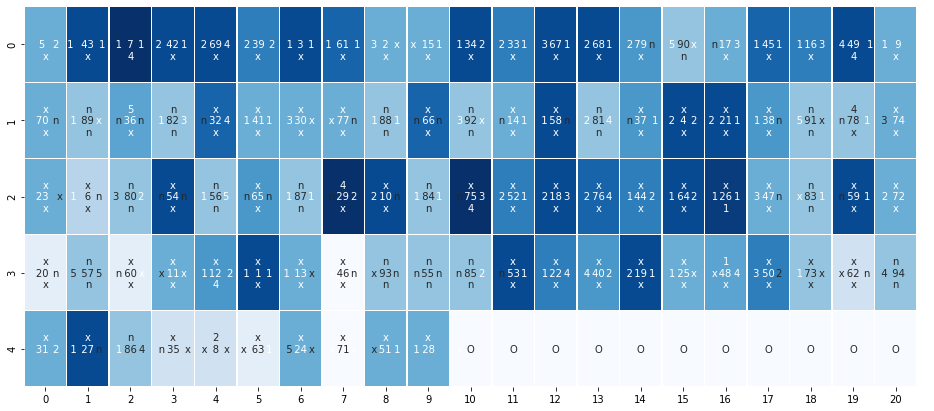

[[81. 58. 14. 38. 91. 93. 72. 59. 83. 20. 57. 60. 22. 53. 85. 52. 18. 76.
  44. 64. 26.]
 [37.  4. 21. 28. 51. 70. 89. 33. 15. 34. 35. 86. 27. 31. 75. 84. 10. 29.
  87. 65. 47.]
 [ 7. 43.  5. 61.  3. 39.  2. 42. 69. 11. 12.  1. 13. 74. 78.  8. 32. 41.
  30. 88. 66.]
 [36. 46. 82. 73. 50. 48. 45. 16. 17. 67. 68. 79. 90. 23.  6. 80. 54. 56.
  77. 92.  0.]
 [ 9. 49. 63. 24. 40. 19. 25. 94. 62. 55. 71.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.]]
Side by Side: First Choice: 53
# of people No Preferences 18
Not in Top 5: [47, 71]
Verticle Happy: [47, 71]


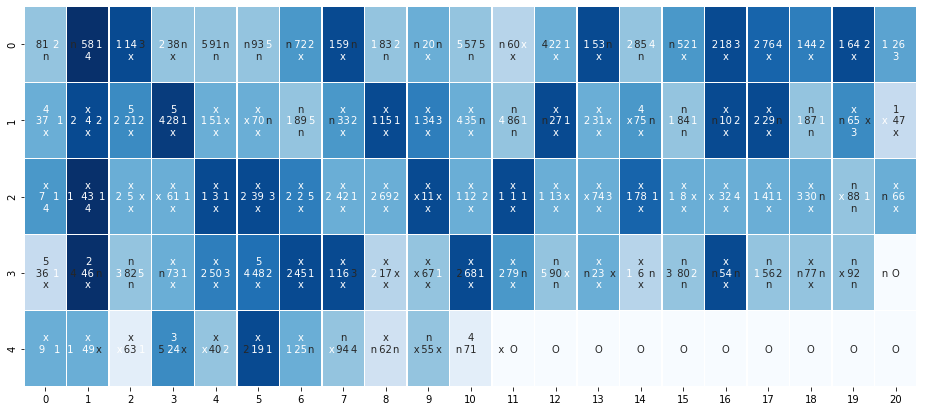

In [27]:
obj = Students()

In [11]:
df.loc[7]

First Person     43.0
Second person    42.0
Third person      5.0
Fourth person    36.0
Fifth person     82.0
Name: 7, dtype: float64

In [192]:
obj.solutions

In [225]:
df.loc[40]

First Person     57.0
Second person    19.0
Third person     25.0
Fourth person    22.0
Fifth person     53.0
Name: 40, dtype: float64

In [3]:
[[18. 52. 76. 44. 64. 26. 47. 67. 68. 79.]
 [ 2. 61.  3. 39. 69. 42.  7. 43.  5. 90.]
 [73. 50. 48. 45. 16. 17. 36. 46. 82. 32.]
 [53. 22. 57. 60. 49.  9. 58. 14. 38. 91.]
 [85. 75. 84. 10. 29. 87. 65. 88. 66. 92.]
 [25. 19. 40. 11. 12.  1. 13. 77. 56. 54.]
 [71. 80.  6. 23.  8. 78. 74. 93. 72. 59.]
 [37.  4. 21. 28. 51. 34. 15. 33. 89. 70.]
 [81. 30. 41. 31. 27. 86. 35. 20. 83.  0.]
 [24. 63. 62. 94. 55.  0.  0.  0.  0.  0.]]
Side by Side: First Choice: 55
Not in Top 5: []
Verticle Happy: []

1